# Read a Graph

First we load the image and do a Hough transform that only looks for horizontal and vertical lines.

In [116]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import IPython
import scipy.ndimage as ndimage
# try:
#     import Image
# except ImportError:
from PIL import Image
import pytesseract as tes

import sys
sys.path.insert(0, './functions')
import ocr_tools
import find_axes
from thresholding import adaptive_thresh

In [119]:
example = 'examples/example105.jpg'
img = cv2.imread(example)
m,n,p=img.shape

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
# blur = cv2.GaussianBlur(img,(3,3),0)
# gray_blur = cv2.cvtColor(blur,cv2.COLOR_BGR2GRAY)
# r,bw = th3 = cv2.threshold(gray,127,255,cv2.THRESH_BINARY)
# ret2,bw2 = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# ret3,bw3 = cv2.threshold(gray_blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
bw4 = adaptive_thresh(gray)
nbw = (255-bw4)

<IPython.core.display.Javascript object>


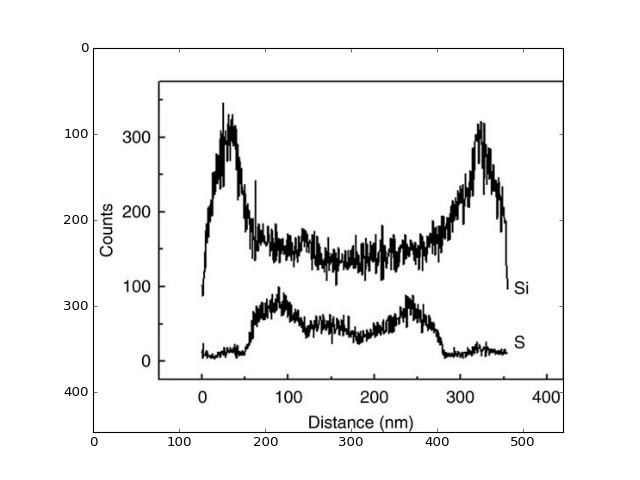

In [120]:
linesP = cv2.HoughLinesP(nbw,1,np.pi/2,2, minLineLength = nbw.shape[1]/10, maxLineGap = 3)[0]

%matplotlib notebook

implot = plt.imshow(img)

## Finding axes - Hough Transform

Now we define the axis score, [cos^2, fractional length, fractional y-coord (or x coord for y axis)]

And we find the lines with the scores closest to these to be our x and y axes


In [121]:
import find_axes
# print(linesP)
xax = find_axes.get_xaxis(linesP,nbw)
print(xax)
yax = find_axes.get_yaxis(linesP,nbw)
print(yax)


[ 75 385 546 385]
[ 77 384  77  41]


## Draw the axes

In [122]:
imlabel = img.copy();
cv2.line(imlabel,(xax[0],xax[1]),(xax[2],xax[3]),(255,0,0),2)
cv2.line(imlabel,(yax[0],yax[1]),(yax[2],yax[3]),(255,0,0),2)

<IPython.core.display.Javascript object>


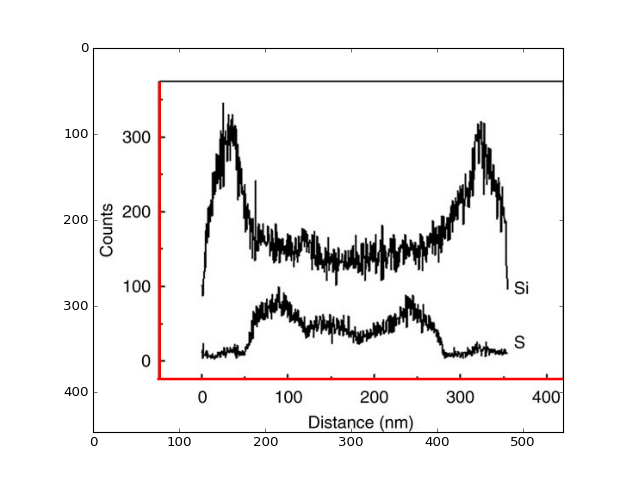

In [123]:
%matplotlib notebook

implot = plt.imshow(imlabel)
implot.set_cmap('gray')

## OCR to find Tick Labels

First we mask the image to read the text below the x-axis, removing the x-axis and its tick labels

<IPython.core.display.Javascript object>


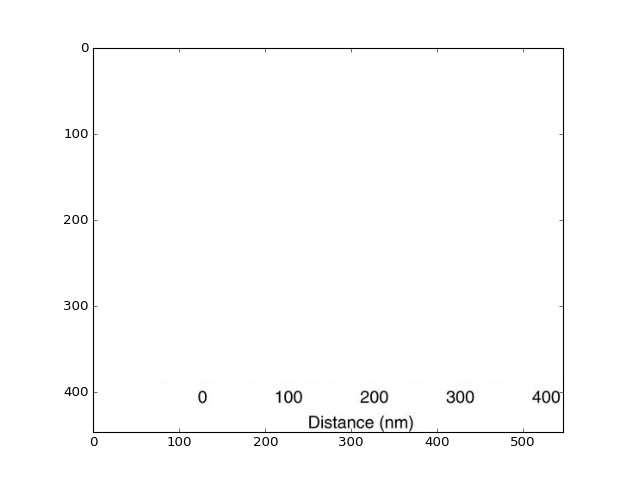

In [124]:
%matplotlib notebook

# Find where the x-ticks stop and crop the text image to be below that
below_xax_bw = np.zeros([m,n]).astype('uint8')
below_xax_bw[xax[1]:,:]=nbw[xax[1]:,:]
row_sums = below_xax_bw.sum(axis=1)
row_sums[0:xax[1]] = 1000
row_sums_list = row_sums.tolist()
text_crop_ind = row_sums_list.index(0)
text_crop_ind

xTextImg = np.ones([m,n,p]).astype('uint8')*255
xTextImg[text_crop_ind+1:,:,:]=img[text_crop_ind+1:,:,:]

cv2.imwrite('temp/xtext.png',xTextImg)
implot = plt.imshow(xTextImg)


In [126]:
xocr = tes.image_to_string(Image.open('temp/xtext.png'),boxes=True)

In [127]:
import ocr_tools

words = ocr_tools.clean_ocr_results(xocr)
words

[['100', 212, 33, 243, 48],
 ['200', 311, 33, 343, 48],
 ['300', 411, 33, 442, 48],
 ['400', 510, 34, 542, 48],
 ['Distance', 251, 4, 326, 19],
 ['(nm', 333, 0, 365, 19],
 [')', 367, 0, 372, 19]]

In [128]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

numbers = [w for w in words if is_number(w[0])]
for w in numbers:
    w[0]=float(w[0])
    w[2] = m-w[2]
    w[4] = m-w[4]
    w.append((w[1]+w[3])/2)
    w.append((w[2]+w[4])/2)
    
xt_labels = np.array(numbers)

<IPython.core.display.Javascript object>


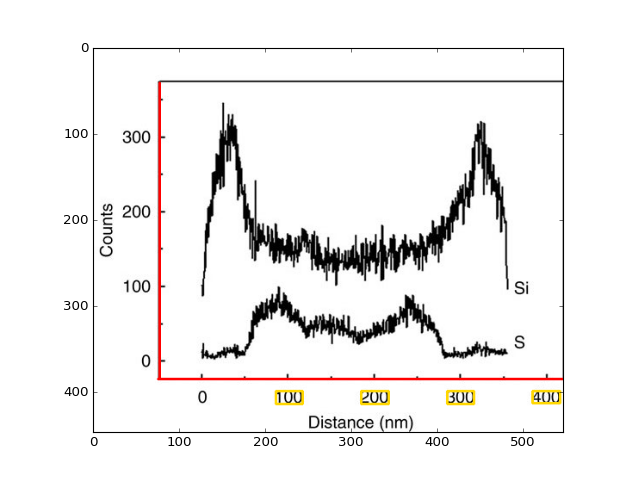

In [129]:
%matplotlib notebook

for w in numbers:
    cv2.rectangle(imlabel, (w[1],w[2]), (w[3],w[4]), (255,215,0), thickness=2, lineType=8, shift=0)

implot = plt.imshow(imlabel)

# Find X Ticks


## More Hough
transform on this image, looking only for vertical lines.

We then sort the results by x-coordinate and remove duplicates that are adjacent to each other by less than 5 pixels.

Finally we accept as ticks vertical lines that are separated from one another by the median spacing of all of the lines.

In [130]:
xt_dirty = find_axes.get_xticks(nbw,xax,tickMargin=11,minTickLen=0,maxGap=0)
xt_list=xt_dirty.tolist()

In [131]:
xt_match = find_axes.match_xticks(numbers,xt_list)
xt_pts = [xt_list[i] for i in xt_match]
xt_pts

[[227, 386, 227, 384],
 [327, 386, 327, 379],
 [426, 386, 426, 379],
 [526, 386, 526, 379]]

<IPython.core.display.Javascript object>


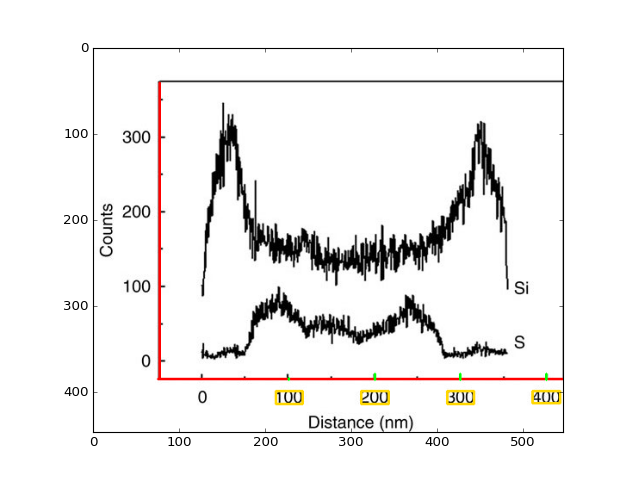

In [132]:
%matplotlib notebook
for x1,y1,x2,y2 in xt_pts:
    cv2.line(imlabel,(x1,y1),(x2,y2),(0,255,0),2)

implot = plt.imshow(imlabel)

In [135]:
xt_pts_array = np.array(xt_pts)
xt_pts_array[:,0].reshape(-1,1)

array([[227],
       [327],
       [426],
       [526]])

In [136]:
xt_labels[:,0].reshape(-1,1)

array([[ 100.],
       [ 200.],
       [ 300.],
       [ 400.]])

## Convert x-axis from pixel space to data space with regression

We have a sort of calibration curve between pixel space and data space.

<IPython.core.display.Javascript object>


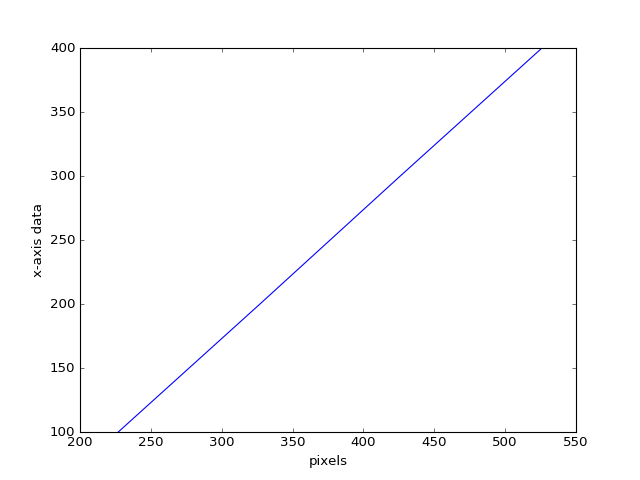

In [137]:
%matplotlib notebook
hcalib = plt.plot(xt_pts_array[:,0].reshape(-1,1), xt_labels[:,0].reshape(-1,1))
plt.xlabel('pixels')
plt.ylabel('x-axis data')

In [138]:
from sklearn import datasets, linear_model
regrx = linear_model.LinearRegression(fit_intercept=True)

regrx.fit(xt_pts_array[:,0].reshape(-1,1), xt_labels[:,0].reshape(-1,1))

# The coefficients
print 'Coefficients: \n', regrx.coef_
print 'Intercept: \n', regrx.intercept_

Coefficients: 
[[ 1.00401202]]
Intercept: 
[-128.01052398]


## Now Get Y Ticks

In [140]:
# Find where the y-ticks stop and crop the text image to be left of that
left_yax_bw = np.zeros([m,n]).astype('uint8')
left_yax_bw[:yax[0],:]=nbw[:yax[0],:]
col_sums = left_yax_bw.sum(axis=0)
col_sums[yax[0]:] = 1000
col_zeros=np.where(col_sums==0)[0]
y_crop_ind=col_zeros[-1]

<IPython.core.display.Javascript object>


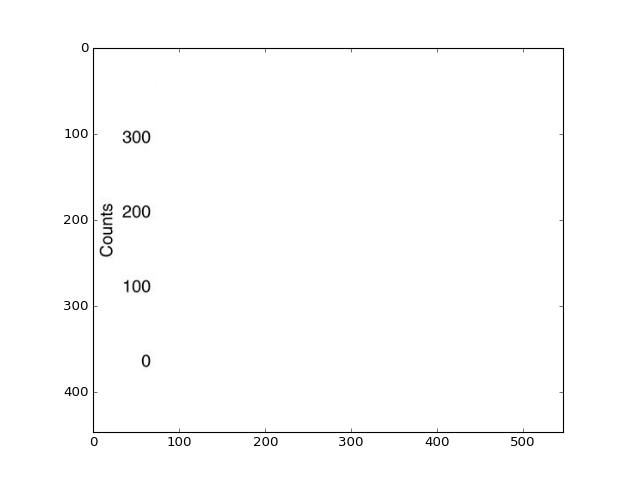

In [141]:
%matplotlib notebook
yTextImg = np.ones([m,n,p]).astype('uint8')*255
yTextImg[:,0:y_crop_ind-1,:]=img[:,0:y_crop_ind-1,:]

cv2.imwrite('temp/ytext.png',yTextImg)
implot = plt.imshow(yTextImg)

## Unfortunately

For OCR to work effectively on the y-axis, we must remove the rotated axis title completely. This is quite challenging.

<IPython.core.display.Javascript object>


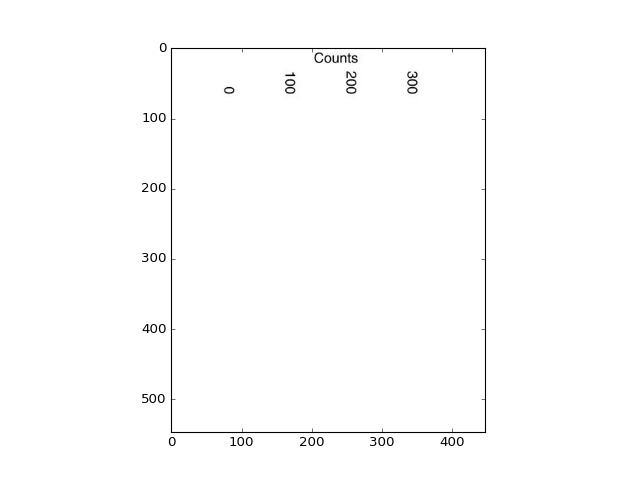

In [142]:
%matplotlib notebook

yTextRot = ndimage.interpolation.rotate(yTextImg, -90)
cv2.imwrite('temp/ytextrot.png',yTextRot)
implot = plt.imshow(yTextRot)
implot.set_cmap('gray')

In [144]:
yRotOcr = tes.image_to_string(Image.open('temp/ytextrot.png'),boxes=True)

### Find the longest "word" and clear its bounding box

In [145]:
yrot_words = ocr_tools.clean_ocr_results(yRotOcr,charspace=10)
word_length = [len(i[0]) for i in yrot_words]
longest_word = np.array(word_length).argmax()
lwbox = yrot_words[longest_word]
lwbox

['Counts', 203, 524, 265, 539]

In [146]:
x1 = lwbox[1]-1
y1 = lwbox[2]-1
x2 = lwbox[3]+1
y2 = lwbox[4]+1
y1 = n-y1
y2 = n-y2
yTextRot[y2:y1+1,x1:x2+1,:] = np.ones([y1-y2+1,x2-x1+1,3]).astype('uint8')*255
yText_Clean = ndimage.interpolation.rotate(yTextRot, 90)

<IPython.core.display.Javascript object>


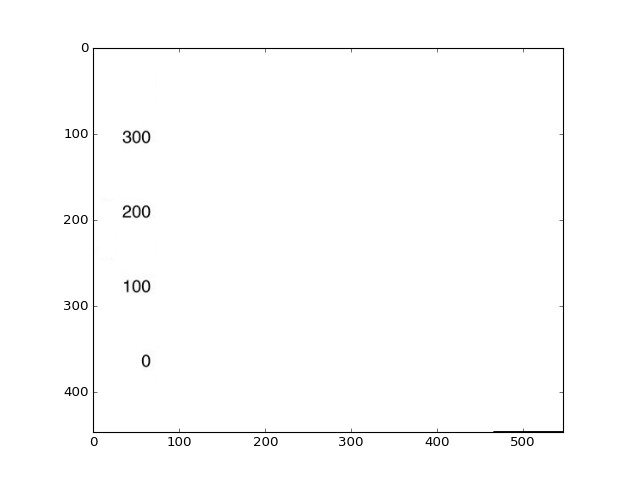

In [147]:
%matplotlib notebook
implot = plt.imshow(yText_Clean)

### Conventional OCR

In [148]:
cv2.imwrite('temp/ytextclean.png',yText_Clean)
yocr = tes.image_to_string(Image.open('temp/ytextclean.png'),boxes=True)
yl_ocr = ocr_tools.clean_ocr_results(yocr)
yl_ocr

[['300', 35, 335, 66, 350],
 ['200', 35, 249, 66, 263],
 ['100', 36, 162, 66, 176]]

In [149]:
yt_numbers = [w for w in yl_ocr if is_number(w[0])]
for w in yt_numbers:
    w[0]=float(w[0])
    w[2] = m-w[2]
    w[4] = m-w[4]
    w.append((w[1]+w[3])/2)
    w.append((w[2]+w[4])/2)
    
yt_label_array = np.array(yt_numbers)
yt_label_array

array([[ 300.,   35.,  112.,   66.,   97.,   50.,  104.],
       [ 200.,   35.,  198.,   66.,  184.,   50.,  191.],
       [ 100.,   36.,  285.,   66.,  271.,   51.,  278.]])

<IPython.core.display.Javascript object>


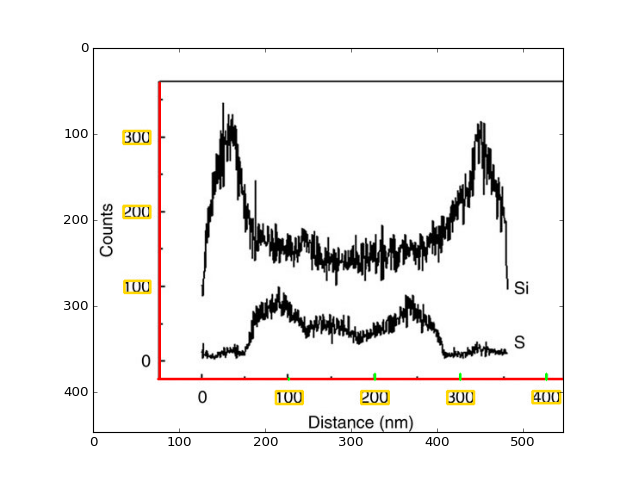

In [150]:
%matplotlib notebook

for w in yt_numbers:
    cv2.rectangle(imlabel, (w[1],w[2]), (w[3],w[4]), (255,215,0), thickness=2, lineType=8, shift=0)

implot = plt.imshow(imlabel)

## Now run the same label/tick matching algorithm for the y-axis

In [151]:
yt_dirty = find_axes.get_yticks(nbw,yax,tickMargin=11,minTickLen=0,maxGap=2)
yt_list=yt_dirty.tolist()

In [152]:
yt_match = find_axes.match_xticks(yt_numbers,yt_list)
yt_pts = [yt_list[i] for i in yt_match]
yt_pts

[[75, 104, 82, 104], [66, 190, 66, 190], [75, 278, 83, 278]]

<IPython.core.display.Javascript object>


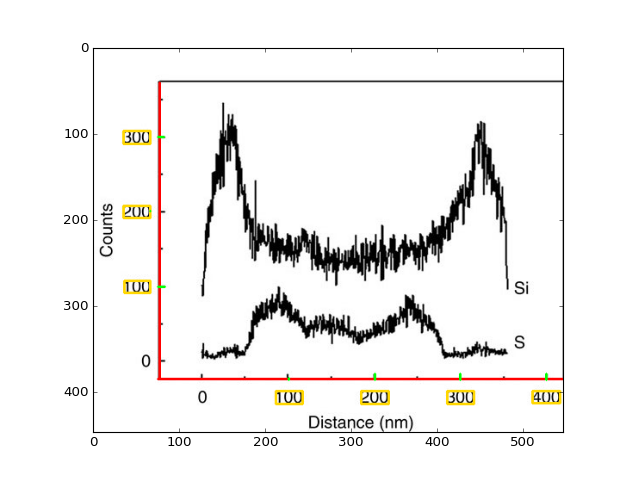

In [153]:
%matplotlib notebook
for x1,y1,x2,y2 in yt_pts:
    cv2.line(imlabel,(x1,y1),(x2,y2),(0,255,0),2)

implot = plt.imshow(imlabel)

In [155]:
yt_pts_array = np.array(yt_pts)
yt_pts_array[:,1].reshape(-1,1)

array([[104],
       [190],
       [278]])

In [156]:
yt_label_array[:,0].reshape(-1,1)

array([[ 300.],
       [ 200.],
       [ 100.]])

## Regress the y tick labels to the y ticks

In [157]:
from sklearn import datasets, linear_model
regry = linear_model.LinearRegression(fit_intercept=True)

regry.fit(yt_pts_array[:,1].reshape(-1,1), yt_label_array[:,0].reshape(-1,1))

# The coefficients
print 'Coefficients: \n', regry.coef_
print 'Intercept: \n', regry.intercept_

Coefficients: 
[[-1.14937467]]
Intercept: 
[ 419.14743703]


## Finally, Extract the Data by Clustering

In [158]:
from color_series_scrape import color_series_scrape

pix_pts, ROI = color_series_scrape(example, [[xax[0],xax[2]]],[[yax[3],yax[1]]], n_colors=4)


KM: fitting model on a small sub-sample of the data
done fitting
KM: Prediciting color indiced on the full image
done predicting
KM: recreating clustered image


KM: fitting model on a small sub-sample of the data
done fitting
KM: Prediciting color indiced on the full image
done predicting
KM: recreating clustered image


<IPython.core.display.Javascript object>


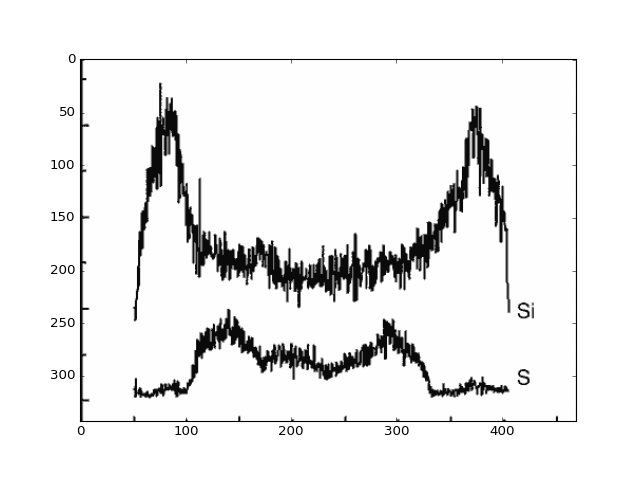

In [162]:
from cluster_data import cluster_colorspace_km, return_series

im_recon, im_label = cluster_colorspace_km(ROI[0], 3)
labels_as_ims = return_series(im_label)

%matplotlib notebook
plt.imshow(im_recon)

<IPython.core.display.Javascript object>


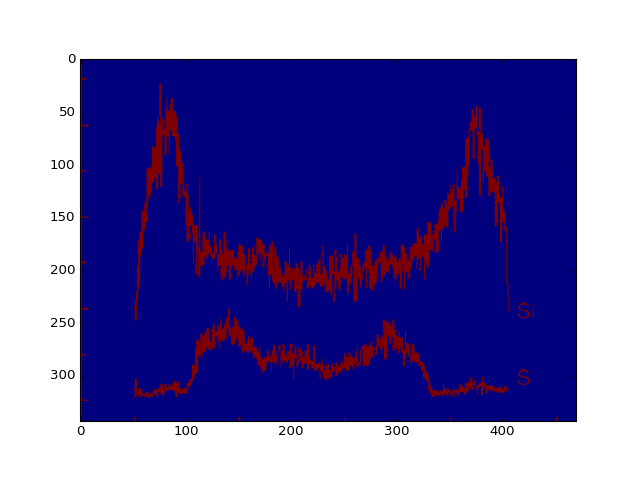

In [163]:
%matplotlib notebook

plt.imshow(labels_as_ims[0])

<IPython.core.display.Javascript object>


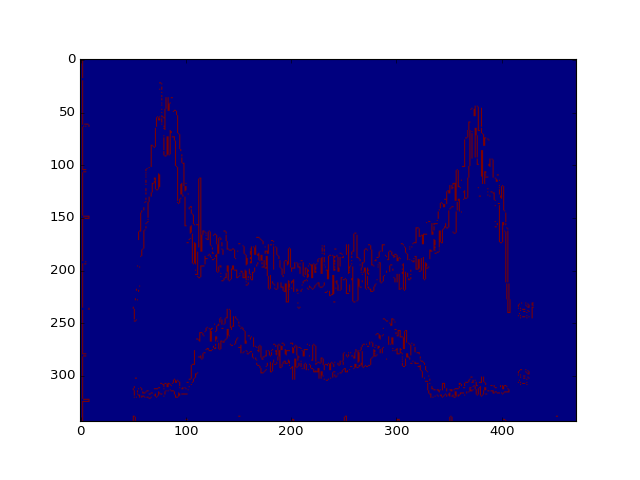

In [168]:
%matplotlib notebook

plt.imshow(labels_as_ims[1])

In [165]:
%matplotlib notebook

plt.imshow(labels_as_ims[2])

IndexError: list index out of range

<IPython.core.display.Javascript object>


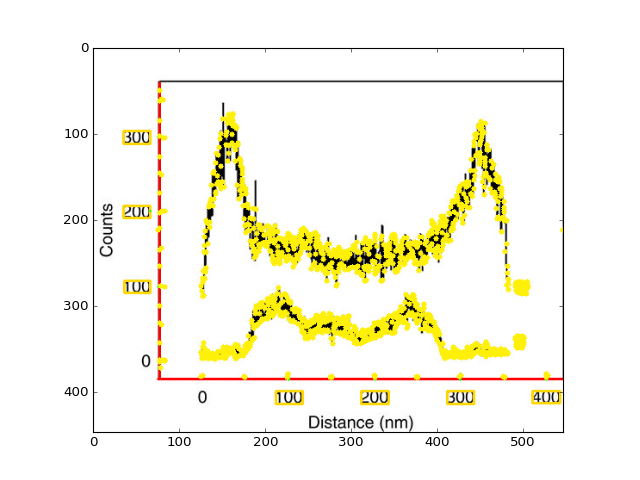

In [166]:
%matplotlib notebook
imlabel4 = imlabel.copy()
pp_list = []
for series in pix_pts[0]:
    s_list = []
    for tup in series:
        x = int(round(tup[1]))+xax[0]
        y = int(round(tup[0]))+yax[3]
        s_list.append([x,y])
    pp_list.append(s_list)

pp_list

for series in pp_list:
    for pt in series:
        cv2.circle(imlabel4,(pt[0],pt[1]), 3, (255,240,10), -1)


lastplot = plt.imshow(imlabel4)

## ... and convert the pixel values to the units of the axes

In [167]:
data_list = []
for series in pp_list:
    ser_list = []
    for pt in series:
        xdata = pt[0]*regrx.coef_+regrx.intercept_
        ydata = pt[1]*regry.coef_+regry.intercept_
        ser_list.append([xdata[0,0],ydata[0,0]])
    data_list.append(ser_list[::-1])

data_list

[[[220.3816455313401, 52.496917385943277],
  [249.49799399205659, 62.841289413422544],
  [65.76379508477649, 63.990664083142462],
  [81.827987338964903, 73.185661440901868],
  [240.4618858490756, 76.633785450061623],
  [98.896191609040102, 149.04438964241672],
  [86.848047418398778, 153.64188832129645],
  [271.58625834156572, 163.98626034877574],
  [278.61434245277314, 172.0318830368152],
  [292.67051067518798, 199.61687511009333],
  [16.567206306324408, 247.89061123833008],
  [20.583254369871526, 260.53373260524927],
  [33.635410576399636, 303.06059538488637]],
 [[351.90721961250784, -21.063061476131793],
  [200.30140521360454, -21.063061476131793],
  [148.09278038749216, -21.063061476131793],
  [349.89919558073427, -19.913686806411874],
  [250.50200600794341, -21.063061476131793],
  [248.49398197616983, -21.063061476131793],
  [150.10080441926573, -19.913686806411874],
  [47.691578798814504, -19.913686806411874],
  [402.10782040684671, -18.764312136691956],
  [400.09979637507308, -16

## Broader Problem: How to identify Graphs?

In [71]:
spat_stats_path = '/Users/Imperssonator/CC/MIC-Pres/SS PCA presentation/Slide1.tiff'
ss_img = cv2.imread(spat_stats_path)

<IPython.core.display.Javascript object>


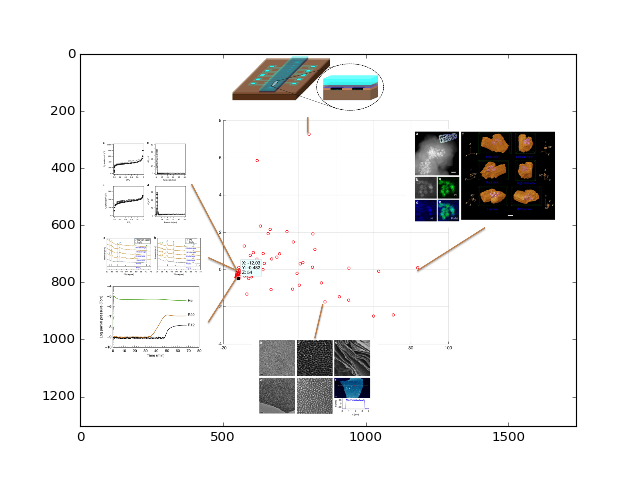

In [72]:
%matplotlib notebook
plt.imshow(ss_img)